In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import supervision as sv

#
# download dataset with a few labelled images (5-10 is recommended, but you can go as high as you like)
#
from roboflow import login,Roboflow

login()
rf = Roboflow()

project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)


You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2967.30it/s]


In [4]:
pred_datasets = []

from random import choice
from PIL import Image
import cv2
from autodistill_seggpt.dataset_utils import label_dataset

valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
    force_masks=True
)

In [5]:
def show_img(dataset: sv.DetectionDataset, name=None):

    if name is None:
        name = choice(list(dataset.images.keys()))
    if type(name) == int:
        name = sorted(list(dataset.images.keys()))[name]

    detections = dataset.annotations[name]
    img = dataset.images[name]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotator = sv.MaskAnnotator()

    annotated_frame = annotator.annotate(
        scene=img,
        detections=detections
    )

    return Image.fromarray(annotated_frame)

In [9]:
from autodistill_seggpt.find_best_examples import find_best_ensembles, imgset_entries

best_ensembles = find_best_ensembles(climbing_dataset,valid_dataset)

Finding best ensemble for class 0-climbing-holds.
Finding best ensemble for class 1-climbing-holds.
making singletons.


Best IoU: 0.65: 100%|██████████| 7/7 [00:46<00:00,  6.70s/it]


making 2-image pairs.


100%|██████████| 3/3 [01:50<00:00, 36.77s/it]


merging ensembles.


Best IoU: 0.65: 100%|██████████| 10/10 [23:58<00:00, 143.84s/it]


Finding best ensemble for class 2-floor.
making singletons.


Best IoU: 0.83: 100%|██████████| 7/7 [00:23<00:00,  3.35s/it]


making 2-image pairs.


100%|██████████| 3/3 [01:42<00:00, 34.20s/it]


merging ensembles.


Best IoU: 0.86: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


Finding best ensemble for class 3-person.
making singletons.


Best IoU: 0.87: 100%|██████████| 7/7 [00:36<00:00,  5.20s/it]


making 2-image pairs.


Best IoU: 0.87: 100%|██████████| 3/3 [01:42<00:00, 34.07s/it]


merging ensembles.


Best IoU: 0.87: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


In [6]:
from autodistill_seggpt.find_best_examples import imgset_entries
len(imgset_entries)
demo_dataset = imgset_entries[0][1]

from autodistill_seggpt.dataset_utils import extract_classes_from_dataset
gt_demo_dataset = extract_classes_from_dataset(valid_dataset,[1])

show_img(demo_dataset,0)

from autodistill_seggpt.metrics import iou
iou(gt_demo_dataset, demo_dataset)

IndexError: list index out of range

In [7]:

from autodistill_seggpt import SegGPT,FewShotOntology

for i in range(1):
    climbing_ontology = FewShotOntology(climbing_dataset)

    base_model = SegGPT(
        ontology=climbing_ontology
    )

    pred_dataset = label_dataset(valid_dataset, base_model, use_tqdm=True)
    pred_datasets.append(pred_dataset)

Finding best examples for class 1-climbing-holds.


Best/Last IoU: 0.37/0.37: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


Finding best examples for class 2-floor.


Best/Last IoU: 0.4/0.4: 100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


Finding best examples for class 3-person.


100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


: 

In [ ]:
from autodistill_seggpt.metrics import iou
from autodistill_seggpt.dataset_utils import extract_classes_from_dataset
gt_dataset = extract_classes_from_dataset(valid_dataset, range(1,len(valid_dataset.classes)))
print(iou(gt_dataset, pred_dataset))

0.673961214211431


In [ ]:
def show_side_by_side(img_name:str):
    # show detections for this image from all pred_datasets.
    # put them side-by-side in one PIL Image.

    num_datasets = len(pred_datasets)

    img = valid_dataset.images[img_name]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotator = sv.MaskAnnotator()

    # make new img with dimensions of img, but with num_datasets times the width
    ret_img = Image.new(
        "RGB", (img.shape[1] * num_datasets, img.shape[0]), color=(255, 255, 255)
    )

    # paste each image into the new image
    for i,pred_dataset in enumerate(pred_datasets):
        detections = pred_dataset.annotations[img_name]
        tmp_img = annotator.annotate(scene=img,detections=detections)
        tmp_img = Image.fromarray(tmp_img)
        # paste tmp_img into ret_img
        x_offset = i * img.shape[1]
        ret_img.paste(tmp_img, (0, x_offset))
    return ret_img

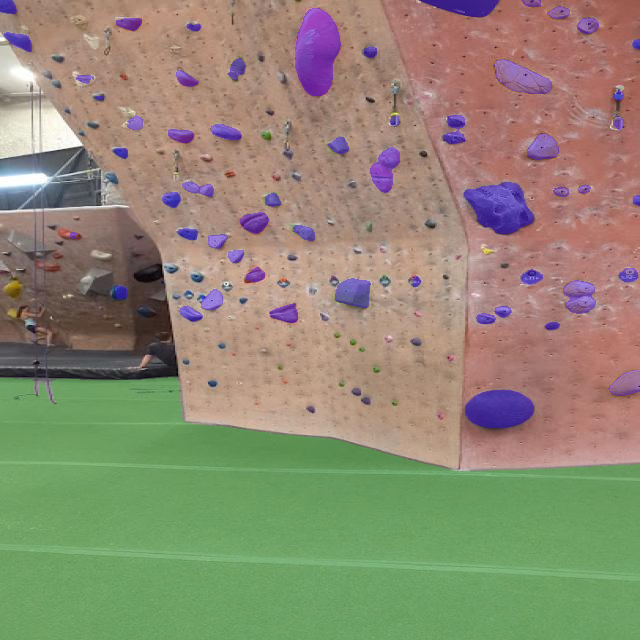

In [ ]:
name = choice(list(valid_dataset.images.keys()))

show_side_by_side(name)